In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')

In [8]:
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
# Загрузка основного набора
df = pd.read_parquet("transaction_fraud_data.parquet")

# Загрузка курсов валют
exchange = pd.read_parquet("historical_currency_exchange.parquet")

In [11]:
# Приведение временных признаков
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

In [13]:
# Приводим валюту к USD по историческому курсу
exchange['date'] = pd.to_datetime(exchange['date']).dt.date
#df['date'] = pd.to_datetime(df['date']).dt.date


# Объединяем по дате
df = df.merge(exchange, on='date', how='left')

# Вычисляем сумму в долларах
df['amount_usd'] = df.apply(
    lambda row: row['amount'] / row[row['currency']]
    if pd.notnull(row[row['currency']]) else np.nan, axis=1
)

# Удалим курсы валют после пересчета
df.drop(columns=exchange.columns.difference(['date']), inplace=True)

In [48]:
print("Размер набора данных:", df.shape)

Размер набора данных: (7483766, 29)


In [15]:
# Пропуски
display(df.isnull().sum().sort_values(ascending=False).head(10))

transaction_id             0
device                     0
day_of_week                0
hour                       0
date                       0
is_fraud                   0
last_hour_activity         0
is_weekend                 0
is_high_risk_vendor        0
is_outside_home_country    0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 29 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [51]:
df.sample(5)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,hour,day_of_week,amount_usd,unique_merchants,lha_total_amount
56503,TX_8b5871eb,CUST_42113,377133796425035,2024-09-30 07:16:05.242654,Grocery,physical,Kroger,553.65,SGD,Singapore,...,False,False,"{'num_transactions': 140, 'total_amount': 3530...",False,2024-09-30,7,Monday,432.486373,79,3.530227e+06
1414330,TX_c808a72b,CUST_47687,4592032100020519,2024-10-05 20:07:10.135622,Grocery,online,Amazon Fresh,158125.16,NGN,Nigeria,...,False,True,"{'num_transactions': 582, 'total_amount': 1022...",False,2024-10-05,20,Saturday,97.640325,105,1.022642e+08
645855,TX_43107d74,CUST_23703,5621526245741295,2024-10-02 16:44:53.141641,Travel,booking,Expedia,2451.97,EUR,Germany,...,True,False,"{'num_transactions': 393, 'total_amount': 1716...",False,2024-10-02,16,Wednesday,2715.190806,103,1.716664e+07
334553,TX_819b49ba,CUST_82817,379309720879012,2024-10-01 10:28:56.871229,Healthcare,medical,Urgent Care,434.34,AUD,Australia,...,False,False,"{'num_transactions': 2032, 'total_amount': 572...",False,2024-10-01,10,Tuesday,301.015166,105,5.723961e+07
3632848,TX_ea1f8467,CUST_75361,374170949902034,2024-10-15 01:36:29.496982,Education,online,MasterClass,266.88,CAD,Canada,...,False,False,"{'num_transactions': 75, 'total_amount': 13817...",False,2024-10-15,1,Tuesday,193.416177,53,1.381715e+06


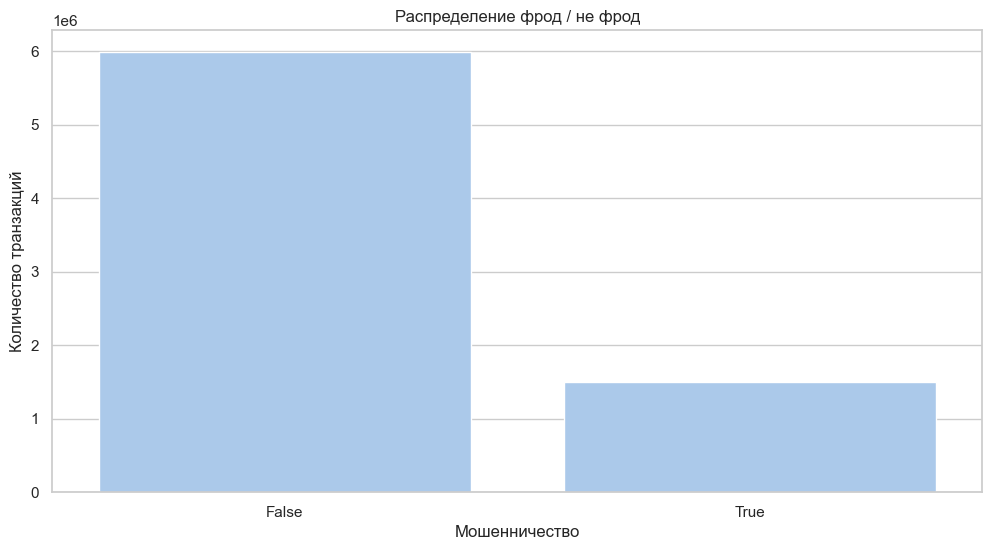

Процент мошеннических транзакций: 19.97%


In [52]:
sns.countplot(x='is_fraud', data=df)
plt.title("Распределение фрод / не фрод")
plt.xlabel("Мошенничество")
plt.ylabel("Количество транзакций")
plt.show()

fraud_rate = df['is_fraud'].mean()
print(f"Процент мошеннических транзакций: {fraud_rate:.2%}")

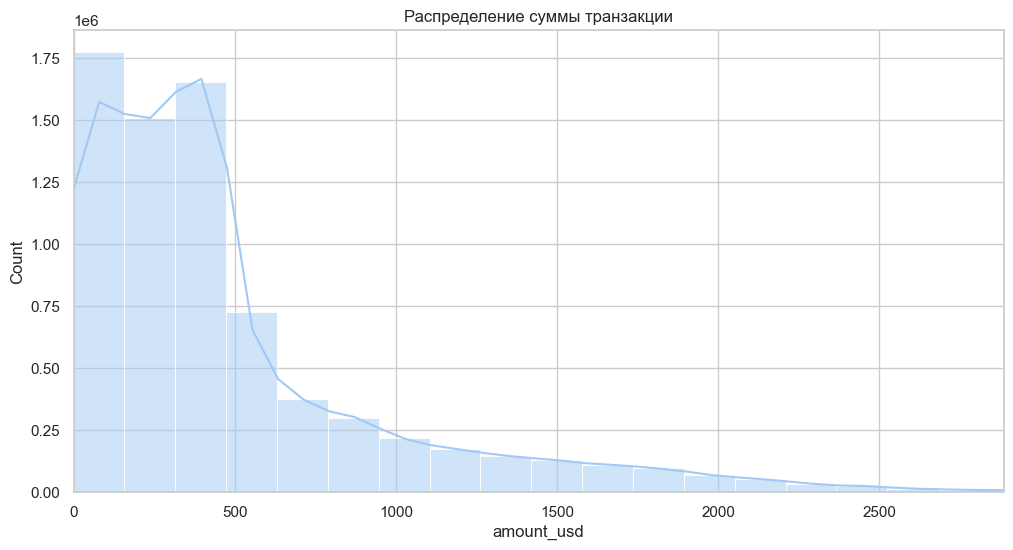

In [68]:
# Распределение суммы
sns.histplot(data=df, x='amount_usd', bins=100, kde=True)
plt.title('Распределение суммы транзакции')
plt.xlim(0, df['amount_usd'].quantile(0.99))  # обрезаем выбросы
plt.show()

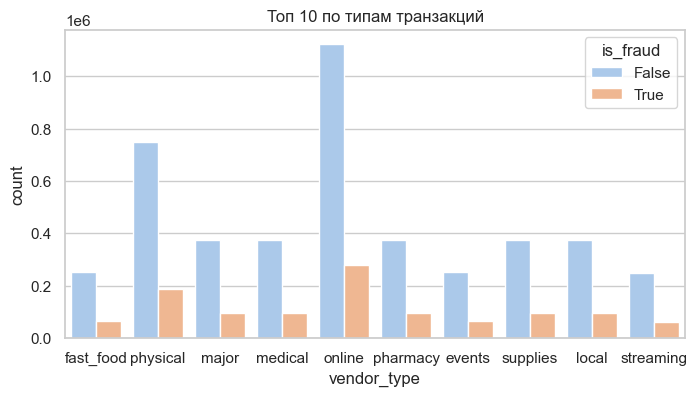

In [70]:
# По типу
plt.figure(figsize=(8,4))
top_types = df['vendor_type'].value_counts().nlargest(10).index
sns.countplot(data=df[df['vendor_type'].isin(top_types)], x='vendor_type', hue='is_fraud')
plt.title("Топ 10 по типам транзакций")
plt.show()

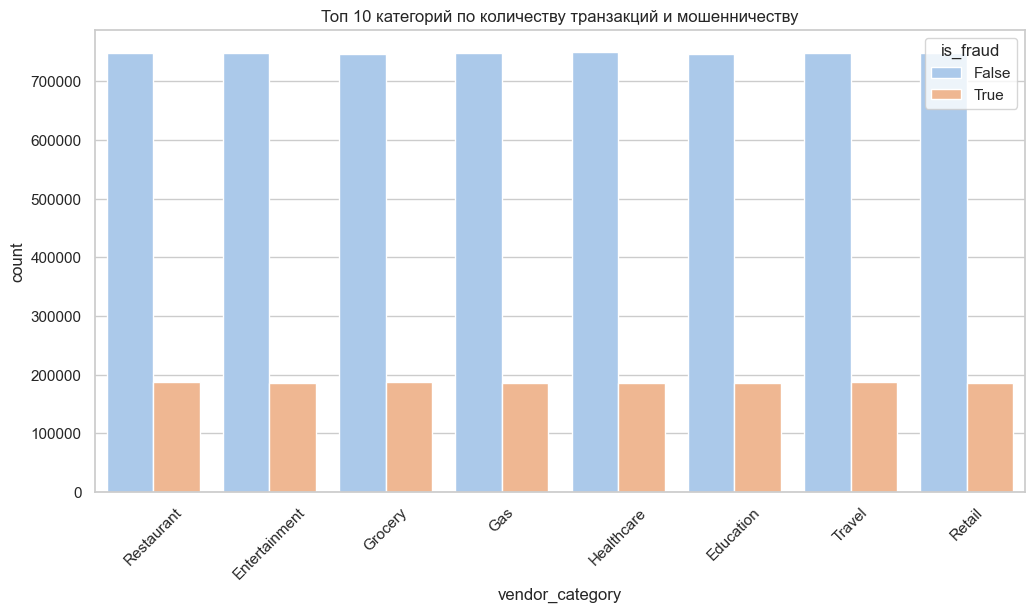

In [65]:
# По категории
top_categories = df['vendor_category'].value_counts().nlargest(10).index
sns.countplot(data=df[df['vendor_category'].isin(top_categories)], x='vendor_category', hue='is_fraud')
plt.xticks(rotation=45)
plt.title("Топ 10 категорий по количеству транзакций и мошенничеству")
plt.show()

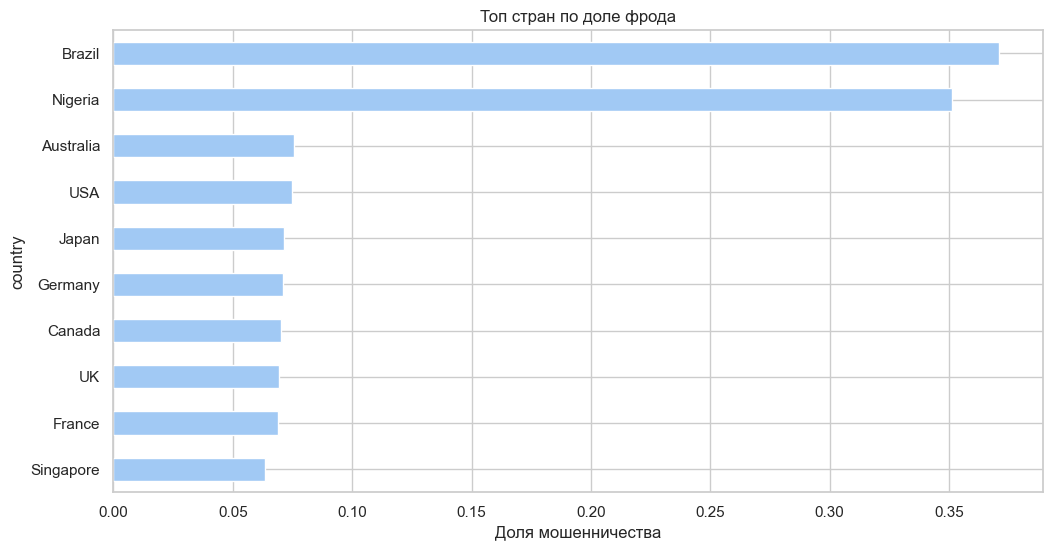

In [24]:
# География
fraud_by_country = df.groupby('country')['is_fraud'].mean().sort_values(ascending=True).head(10)
fraud_by_country.plot(kind='barh', title='Топ стран по доле фрода')
plt.xlabel("Доля мошенничества")
plt.show()

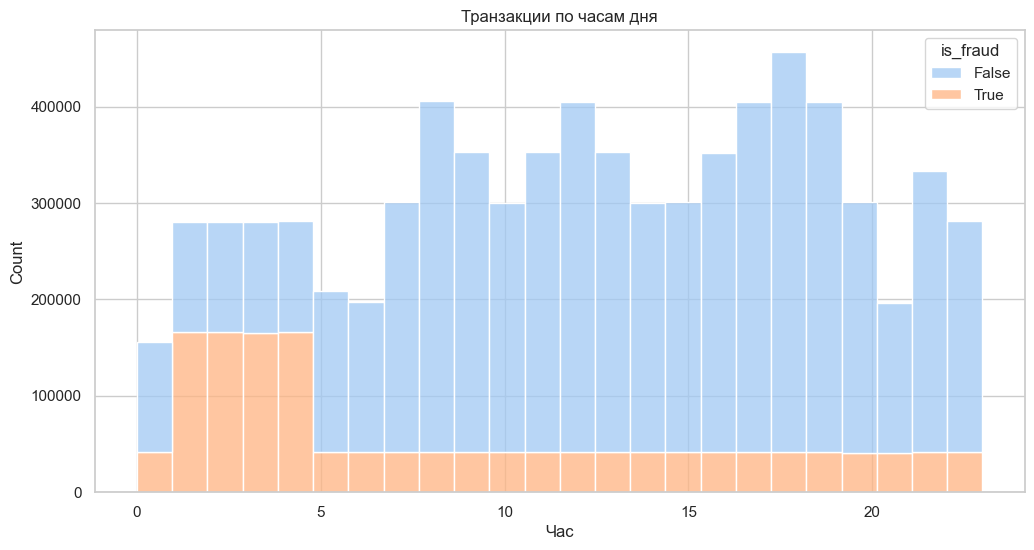

In [21]:
# По времени суток
sns.histplot(data=df, x="hour", hue="is_fraud", bins=24, multiple="stack")
plt.title("Транзакции по часам дня")
plt.xlabel("Час")
plt.show()

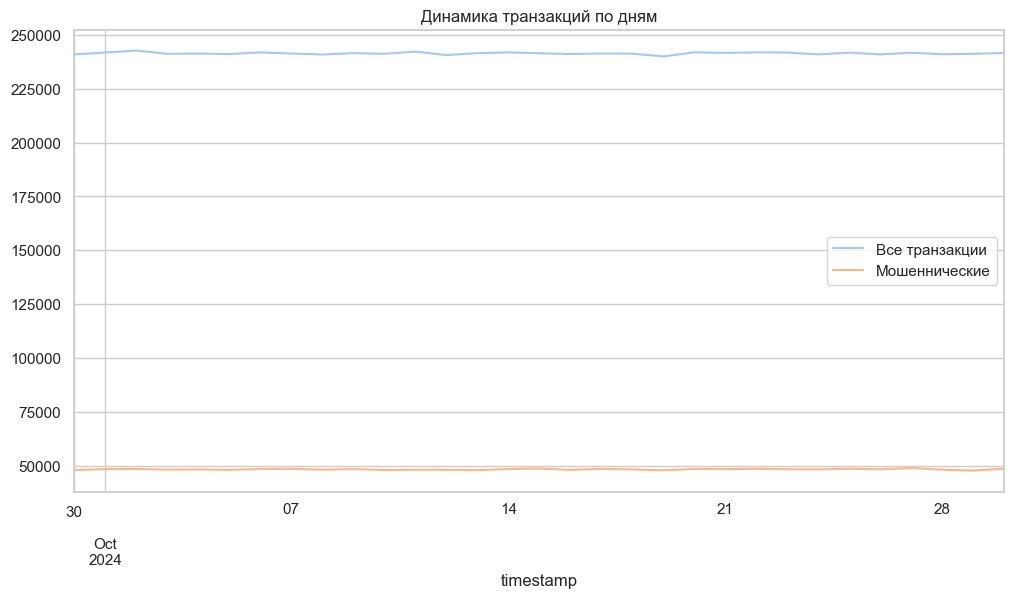

In [58]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Кол-во транзакций по времени
df.set_index('timestamp')['is_fraud'].resample('D').count().plot(label='Все транзакции')
df.set_index('timestamp')['is_fraud'].resample('D').sum().plot(label='Мошеннические')
plt.legend()
plt.title('Динамика транзакций по дням')
plt.show()

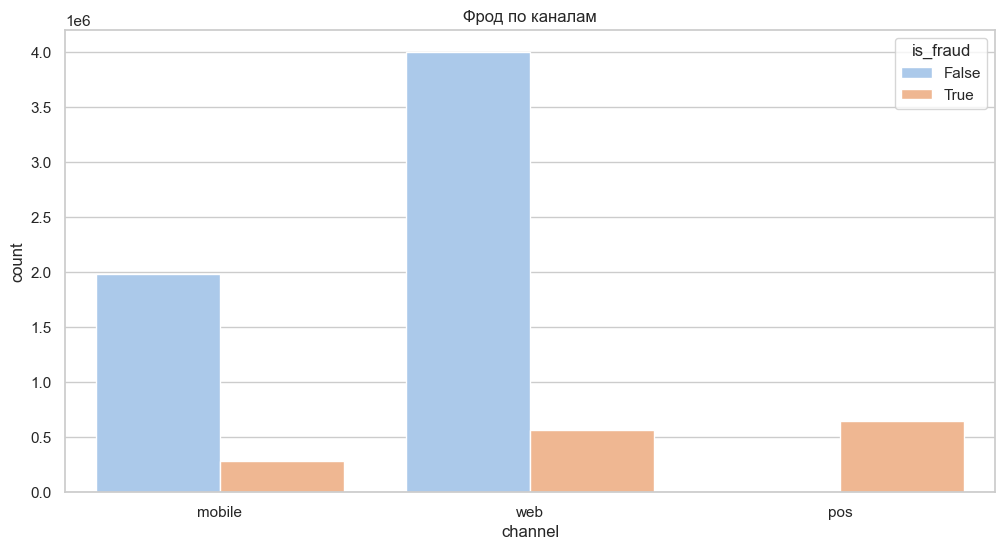

In [22]:
# По каналам
sns.countplot(data=df, x='channel', hue='is_fraud')
plt.title("Фрод по каналам")
plt.show()

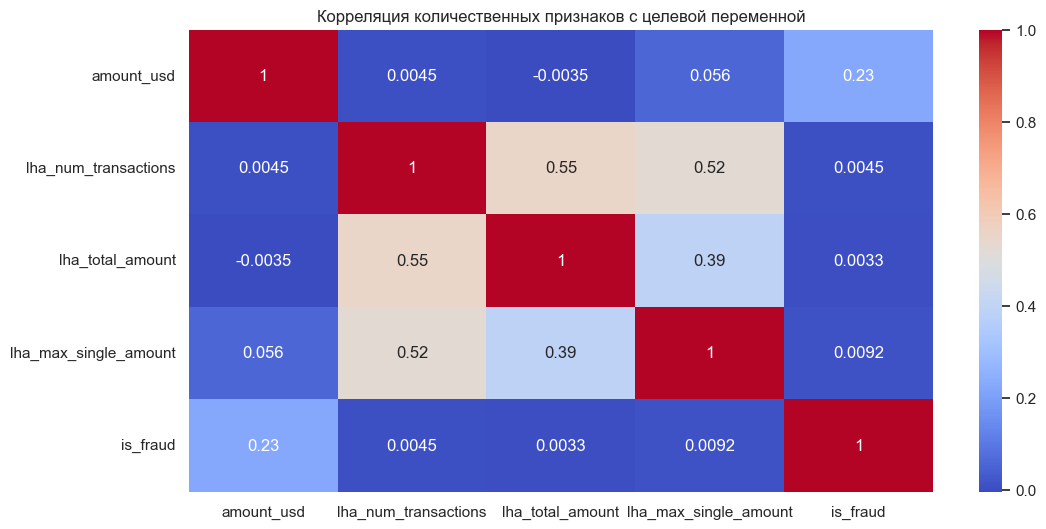

In [26]:
df_corr = pd.DataFrame({
    'amount_usd': df['amount_usd'],
    'lha_num_transactions': df['last_hour_activity'].apply(lambda x: x['num_transactions'] if pd.notnull(x) else np.nan),
    'lha_total_amount': df['last_hour_activity'].apply(lambda x: x['total_amount'] if pd.notnull(x) else np.nan),
    'lha_max_single_amount': df['last_hour_activity'].apply(lambda x: x['max_single_amount'] if pd.notnull(x) else np.nan),
    'is_fraud': df['is_fraud']
})

df_corr = df_corr.dropna()

corr_matrix = df_corr.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляция количественных признаков с целевой переменной")
plt.show()

In [29]:
df['unique_merchants'] = df['last_hour_activity'].apply(lambda x: x['unique_merchants'])

client_medians = df.groupby('customer_id')['unique_merchants'].median().reset_index(name='median_unique_merchants')

quantile_95 = client_medians['median_unique_merchants'].quantile(0.95)

dangerous_clients_count = (client_medians['median_unique_merchants'] > quantile_95).sum()

print(f"Количество клиентов с потенциально опасным поведением: {dangerous_clients_count}")

Количество клиентов с потенциально опасным поведением: 229


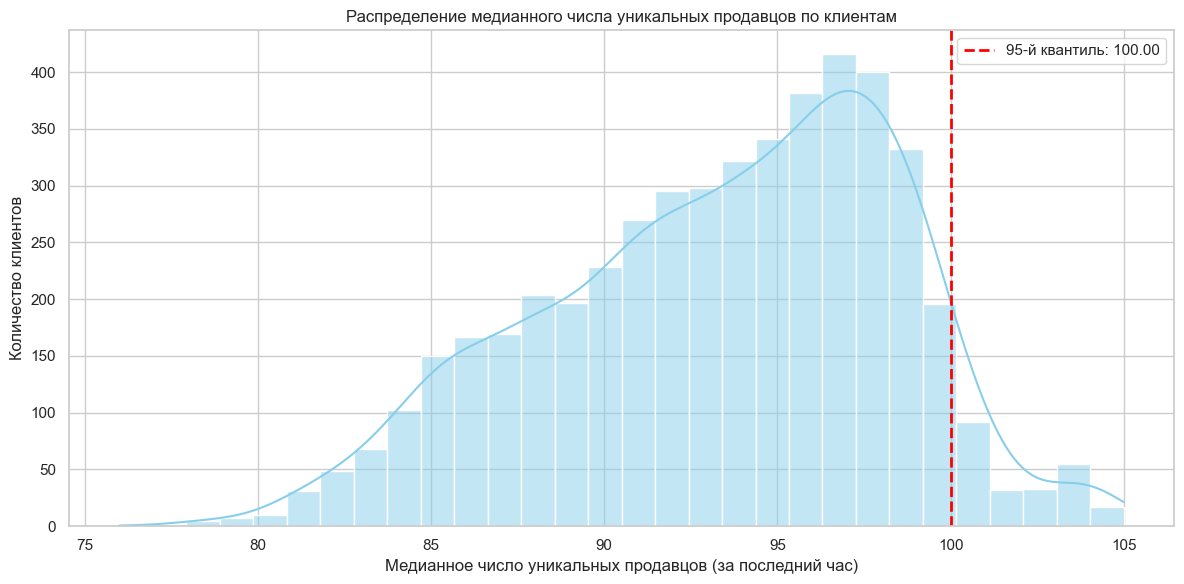

In [71]:
# Гистограмма распределения медианных значений unique_merchants
plt.figure(figsize=(12, 6))
sns.histplot(client_medians['median_unique_merchants'], bins=30, kde=True, color='skyblue')

# Добавляем вертикальную линию на уровне 95-го квантиля
plt.axvline(x=quantile_95, color='red', linestyle='--', linewidth=2, label=f'95-й квантиль: {quantile_95:.2f}')

plt.title('Распределение медианного числа уникальных продавцов по клиентам')
plt.xlabel('Медианное число уникальных продавцов (за последний час)')
plt.ylabel('Количество клиентов')
plt.legend()

plt.tight_layout()
plt.show()

## Продуктовые гипотезы

1. **Фрод чаще совершается в выходные дни и вне страны проживания клиента.**
   → Можно активировать дополнительные проверки безопасности по признакам `is_weekend` и `is_outside_home_country`.

2. **Категории “Путешествия” и “Развлечения” являются высокорисковыми.**
   → Повышать чувствительность антифрод-моделей для этих категорий (`is_high_risk_vendor=True`).

3. **Клиенты из небольших городов чаще становятся жертвами фрода.**
   → Использовать `city_size` для оценки уязвимости сегмента.

4. **Высокая активность в последние 60 минут может указывать на бота или фродера.**
   → Агрегаты `lha_num_transactions`, `lha_max_single_amount` позволяют строить алерты.

## Технические гипотезы

1. **Сильными предикторами фрода являются:**
   - `amount_usd`
   - `lha_max_single_amount`
   - `is_card_present`
   - `is_outside_home_country`
   - `device`

2. **Признак "новое устройство" можно создать как "уникальный device_fingerprint для клиента".**
   → Это позволит обнаруживать смену устройств и создать категорию "новое устройство".

3. **Категориальные признаки можно кодировать через Target Encoding или Leave-One-Out.**
   → Для моделей LightGBM и XGBoost.

4. **Модель может быть обучена с перекрёстной валидацией по времени.**
   → Учитываем `timestamp` и используем TimeSeriesSplit или GroupKFold по `customer_id`.


## Построение baseline-модели

In [62]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline

In [36]:
# Выбираем ключевые признаки
df_model = pd.DataFrame({
    'amount_usd': df['amount_usd'],
    'is_card_present': df['is_card_present'],
    'is_outside_home_country': df['is_outside_home_country'],
    'is_weekend': df['is_weekend'],
    'device': df['device'],
    'channel': df['channel'],
    'vendor_category': df['vendor_category'],
    'city_size': df['city_size'],
    'card_type': df['card_type'],
    'lha_num_transactions': df['last_hour_activity'].apply(lambda x: x['num_transactions'] if pd.notnull(x) else np.nan),
    'lha_total_amount': df['last_hour_activity'].apply(lambda x: x['total_amount'] if pd.notnull(x) else np.nan),
    'lha_max_single_amount': df['last_hour_activity'].apply(lambda x: x['max_single_amount'] if pd.notnull(x) else np.nan),
    'is_fraud': df['is_fraud']
})

df_model = df_model.dropna()

X = df_model.drop(columns='is_fraud')
y = df_model['is_fraud']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [38]:
# Категориальные признаки
cat_features = X.select_dtypes(include='object').columns.tolist()

In [42]:
from sklearn.preprocessing import OrdinalEncoder

# Заменим категориальные признаки Ordinal-кодировкой
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[cat_features] = oe.fit_transform(X_train[cat_features])
X_test_enc[cat_features] = oe.transform(X_test[cat_features])

# Стандартизируем все числовые признаки
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_enc = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test.columns)

In [43]:
model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [44]:
model.fit(X_train_enc, y_train)

[LightGBM] [Info] Number of positive: 1195775, number of negative: 4791237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 5987012, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42)

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.94      0.96   1197810
        True       0.79      0.94      0.85    298944

    accuracy                           0.94   1496754
   macro avg       0.88      0.94      0.91   1496754
weighted avg       0.94      0.94      0.94   1496754

ROC-AUC Score: 0.9876563951314619


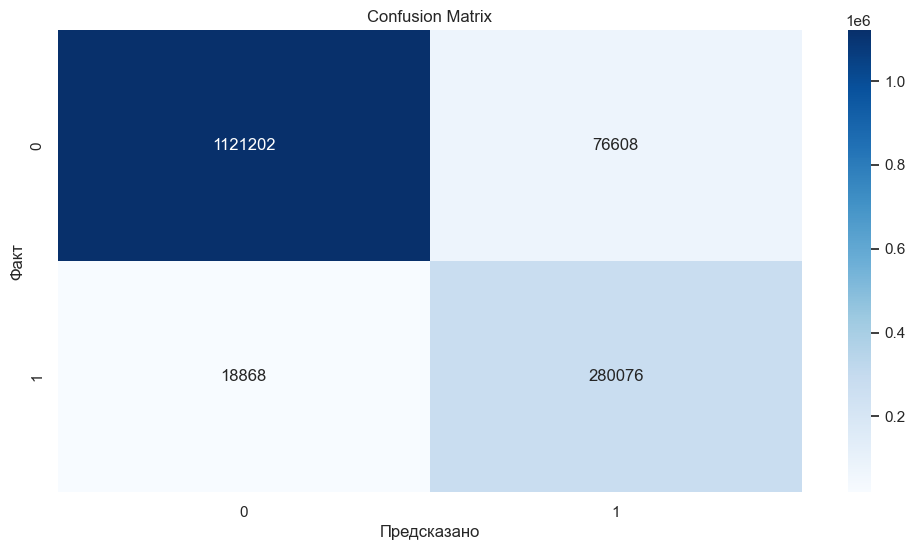

In [61]:
# Предсказания
y_pred = model.predict(X_test_enc)
y_proba = model.predict_proba(X_test_enc)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Предсказано")
plt.ylabel("Факт")
plt.title("Confusion Matrix")
plt.show()

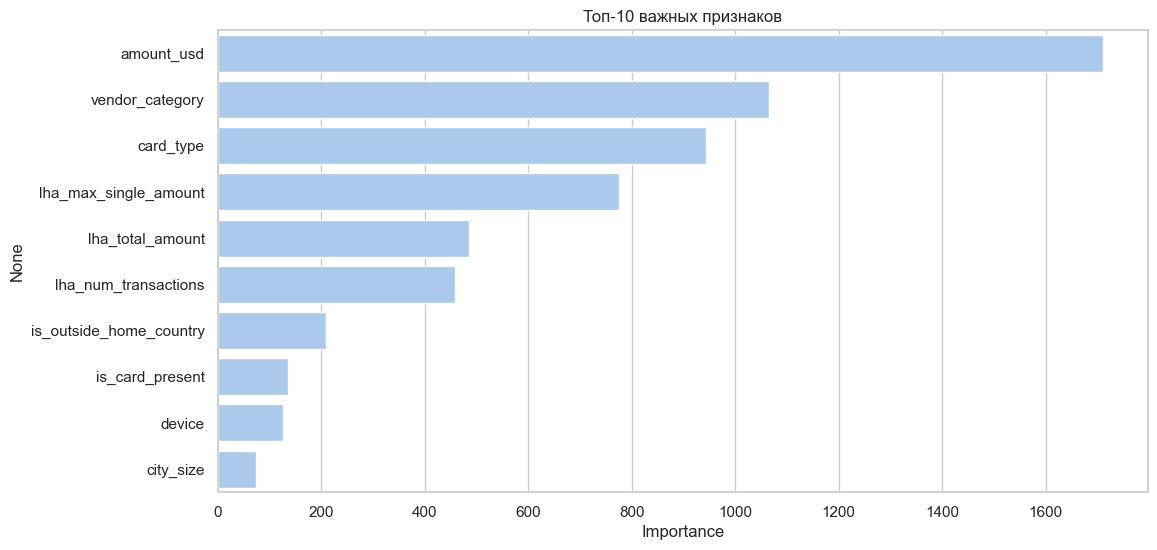

In [72]:
# Важность признаков
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Топ-10 важных признаков")
plt.xlabel("Importance")
plt.show()